# Install detectron2

In [ ]:
### it may be necessary to restart the kernel after installation (for whatever reason)
!pip install --upgrade pip
import torch, torchvision
if torch.version.cuda == '10.0.130':
    !pip install --upgrade pip
    !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
    !pip install cython pyyaml==5.1
    !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
elif torch.version.cuda == '10.1':
    !pip install cython 
    !pip install pyyaml
    !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
else:
    print(torch.version.cuda)

# Imports

In [1]:
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

In [21]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
#from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import random

 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
EXTRA_DATA = PATH/'extra_data'

STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution.csv'

STAGE2_TEST = PATH/'stage2_test_final'
STAGE2_TEST_SAMPLE_SUBMISSION = PATH/'stage2_sample_submission_final.csv'


seed = 19
np.random.seed(seed)

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

# util functions

In [62]:
def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()
    
from matplotlib.pyplot import imshow
def show_pil(path:pathlib.Path):    
    imshow(np.asarray(Image.open(path)))
    plt.show()

def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    return merge_masks([open_mask_as_np(p) for p in path.ls()], shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

!pip install imantics
import imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# some util examples

## load csv

In [ ]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image - example

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask - example

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth - example

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

## Custom dataset for nuclei detection

# Data

## image paths

In [3]:
excluded_ids = ['7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80']

img_paths = [p/'images'/f'{p.name}.png' for p in STAGE1_TRAIN.ls()+STAGE1_TEST.ls()+EXTRA_DATA.ls() if p.name not in excluded_ids]
img_paths_train, img_paths_valid = train_test_split(img_paths, test_size=0.1, random_state=seed)
print(len(img_paths))
print(len(img_paths_train))
print(len(img_paths_valid))

764
687
77


## custom dataset getter

In [63]:
df_rle_labels = pd.concat([pd.read_csv(STAGE1_TRAIN_LABELS), 
                             pd.read_csv(STAGE1_TEST_LABELS)], 
                            ignore_index=True, sort=False)

def get_nuclei_dicts(img_paths:List[pathlib.Path], isTestSet:bool=False):
    """
    Arguments:
        dataset_path: List of pathlib.Path to images
    """    
    dataset_dicts = []
    for path in tqdm(img_paths):
        record = {}
        
        img_pil = PIL.Image.open(path)         
        width = img_pil.width
        height = img_pil.height
        
        record["file_name"] = path
        record["image_id"] = path.stem
        record["height"] = height
        record["width"] = width
        
        
        objs = []
        if not isTestSet:
            ###
            #stage1_test set: masks only in run length encoded form in csv file
            #extra_data set: masks only saved as images
            ###
            try:
                masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
            except FileNotFoundError:
                masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
            
            
            
                for mask in masks:
                    obj = {
                        "bbox": list(mask_to_bbox(mask)),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0
                    }
                    ### detectron throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                    if len(obj["segmentation"][0]) >= 6:
                        objs.append(obj)
                
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## register datasets

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()

DatasetCatalog.register("nuclei_train", lambda : get_nuclei_dicts(img_paths_train))
MetadataCatalog.get(f"nuclei_train").set(thing_classes=["nucleus"])

DatasetCatalog.register("nuclei_valid", lambda : get_nuclei_dicts(img_paths_valid))
MetadataCatalog.get(f"nuclei_valid").set(thing_classes=["nucleus"])

## load datasets

In [ ]:
nuclei_metadata_train = MetadataCatalog.get(f"nuclei_train")
dataset_dicts_nuclei_train = get_nuclei_dicts(img_paths_train)

In [ ]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [ ]:
#for d in dataset_dicts_nuclei:
#    for a in d["annotations"]:
#        polygon = a['segmentation']
#        #print(len(polygon[0]))
#        try:
#            assert len(polygon[0]) % 2 == 0 and len(polygon[0]) >= 6
#        except AssertionError:
#            print(len(polygon[0]))

## sort dataset by number of nuclei and inspect it

In [ ]:
#key: img_path; value: number of nuclei
path_to_n_objects = {}

for ds in [dataset_dicts_nuclei_train, dataset_dicts_nuclei_valid]:
    for d in ds:
        path_to_n_objects[d['file_name']] = len(d['annotations'])
        
#sort descending by number of nuclei
path_to_n_objects = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
print(f'max number of objects: {list(path_to_n_objects.values())[0]}')
print(f'min number of objects: {list(path_to_n_objects.values())[-1]}')

In [ ]:
for k, v in list(path_to_n_objects.items())[300:320]:
    print(k)
    print(v)
    show_pil(k)

## some visualization of the data

In [ ]:
#for d in random.sample(dataset_dicts_nuclei, 3):
for d in dataset_dicts_nuclei_valid[:5]:
    #print(d["file_name"])
    img = cv2.imread(str(d["file_name"]))
    #img = np.asarray(Image.open(p))
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata_valid, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

# config 

In [5]:
from detectron2.config import get_cfg

In [6]:
epochs = 40
bs = 1
iterations = int(len(img_paths_train)/bs*epochs);iterations

27480

In [7]:
output_directory = Path('./output/2')

In [8]:
get_cfg().MODEL.RPN

CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'SMOOTH_L1_BETA': 0.0, 'LOSS_WEIGHT': 1.0, 'PRE_NMS_TOPK_TRAIN': 12000, 'PRE_NMS_TOPK_TEST': 6000, 'POST_NMS_TOPK_TRAIN': 2000, 'POST_NMS_TOPK_TEST': 1000, 'NMS_THRESH': 0.7})

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (f"nuclei_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 20

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 2.5e-3  
cfg.SOLVER.MAX_ITER = iterations
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 0.3*iterations
#cfg.SOLVER.LR_SCHEDULER_NAME = 'OneCycleLR'

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000

cfg['SEED'] = seed

cfg.OUTPUT_DIR = str(output_directory)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train

In [ ]:
from detectron2.engine import DefaultTrainer

In [ ]:
trainer = DefaultTrainer(cfg) 

In [ ]:
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)

In [ ]:
trainer.train()

# Inference & evaluation

In [10]:
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [11]:
cfg.OUTPUT_DIR

'output/2'

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.TEST.DETECTIONS_PER_IMAGE = cfg.MODEL.RPN.POST_NMS_TOPK_TEST

## Validation set

In [ ]:
cfg.DATASETS.TEST = ("nuclei_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [ ]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")

### sort dataset dict by different metrics

#### by relative error in predicted number of instances

In [ ]:
## add number of predicted instances and the relative error to every entry in dataset_dicts_nuclei_valid

for d in tqdm(dataset_dicts_nuclei_valid[:]):
    n_pred = len(predictor(cv2.imread(str(d["file_name"])))['instances'])
    d['n_predicted'] = n_pred
    n_act = len(d['annotations'])
    d['relative_error'] = abs(n_pred-n_act)/n_act    

In [ ]:
## sort it descending by relative_error
dataset_dicts_nuclei_valid.sort(key=lambda d: d['relative_error'], reverse=True)

#### by IoU with ground truth

In [ ]:
# slight modification of this implementation
#https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
SMOOTH = 1e-6
def iou_pytorch(predicted_mask: torch.Tensor, ground_truth_mask: torch.Tensor):    
    intersection = (predicted_mask & ground_truth_mask).float().sum((0, 1))  # Will be zero if Truth=0 or Prediction=0
    union = (predicted_mask | ground_truth_mask).float().sum((0, 1))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [ ]:
for d in tqdm(dataset_dicts_nuclei_valid[:]):
    pred = predictor(cv2.imread(str(d["file_name"])))
    ### merged mask of prediction
    mask_preds = merge_masks(pred['instances'].get('pred_masks').cpu(), shape=(d['height'], d['width']))
    ### merged mask of ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))

    mask_actual = merge_masks(masks, shape=(d['height'], d['width']))
    d['iou'] = iou_pytorch(mask_preds, mask_actual)

In [ ]:
## sort it ascending by iou 
dataset_dicts_nuclei_valid.sort(key=lambda d: d['iou'], reverse=True)

### visualize most wrongly predicted cases

In [ ]:
for n, d in enumerate(dataset_dicts_nuclei_valid[:20]):
    img = cv2.imread(str(d["file_name"]))
    
    ### image with predictions as overlay
    pred = predictor(img)
    n_predicted = len(pred['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_valid, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]

    
    ### merged masks of the ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))
    n_actual = d['annotations']
    print(f'number of actual instances: {len(n_actual)}')
    print(f'number of actual instances: {len(masks)}')
    merged_mask = merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1]))
    
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata_valid, scale=1)
    img_with_actual = visualizer.draw_dataset_dict(d).get_image()[:, :, ::-1]

    
    
    f, axarr = plt.subplots(1,4, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(merged_mask)
    axarr[2].imshow(img_with_actual)
    axarr[3].imshow(img_with_preds)
    plt.show()

## Test set

In [ ]:
DatasetCatalog.clear()

In [ ]:
img_paths_test = [path/'images'/f'{path.name}.png' for path in STAGE2_TEST.ls()];len(img_paths_test)
DatasetCatalog.register("nuclei_test", lambda : get_nuclei_dicts(img_paths_test, isTestSet=True))
MetadataCatalog.get(f"nuclei_test").set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = ("nuclei_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
nuclei_metadata_test = MetadataCatalog.get(f"nuclei_test")
for p in random.sample(img_paths_test, 5):
    img = cv2.imread(str(p))
    pred = predictor(img)
    n_predicted = len(pred['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_test, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   
    )
    img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]
    
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_with_preds)
    plt.show()

### get predictions for stage2 test dataset of dsb 2018

In [ ]:
preds = {}
for p in tqdm(img_paths_test):
    img = cv2.imread(str(p))
    with torch.no_grad():
        pred = predictor(img)
    preds[p.stem] = (pred["instances"].to("cpu"))
    del pred
    torch.cuda.empty_cache()

### create submission for stage2 test dataset of dsb 2018

In [ ]:
df_sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [ ]:
for i, pred in tqdm(list(preds.items())[:]):
    masks = pred.get('pred_masks')
    if len(masks) == 0:
        df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': ''}, ignore_index=True)
    else:
        ###
        # the competition evaluation at kaggle throws an error, if an encoded pixel belongs to more than one object
        ###
        mask_merged = None
        for mask in masks:
            mask = mask.int()
            if mask_merged == None:
                mask_merged = mask
            else:
                overlap = (mask == mask_merged).int()
                mask = mask - overlap
                mask_merged = merge_masks([mask_merged, mask], shape=(mask.shape[0],mask.shape[1]))
            df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': rle_from_list_to_string(rle_encode(mask))}, ignore_index=True)

In [ ]:
df_sub

In [ ]:
submission_path = Path('./submission_detectron2_2.csv')

In [ ]:
df_sub.to_csv(submission_path, index=False)

In [ ]:
pd.read_csv(submission_path)

## Muscles 

In [74]:
import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

PATH_MUSCLES = Path('/home/Deep_Learner/private/datasets/Muskeln')
MUSCLES_WSIS = PATH_MUSCLES/'wsis'
MUSCLES_ROIS = PATH_MUSCLES/'rois'
MUSCLES_TILES = PATH_MUSCLES/'tiles'

muscles_wsi_paths = MUSCLES_WSIS.ls()

### Extract tiles

In [75]:
def naming_func_muscles(wsi_path:pathlib.Path):
    path = Path(wsi_path)
    split = path.stem.split('-')
    return f'{split[0]}'[:]

In [29]:
naming_func_muscles(muscles_wsi_paths[0])

'DKO474_US_hom_1_HE'

In [57]:
df_muscle_tiles = tiles.WsiOrROIToTilesMultithreaded(wsiPaths = MUSCLES_ROIS.ls()[:], 
                                                       tilesFolderPath=MUSCLES_TILES, 
                                                       tileWidth=512, 
                                                       tileHeight=512, 
                                                       tile_naming_func = naming_func_muscles, 
                                                       save_tiles=True,
                                                        tileScoringFunction = tiles.scoring_function_1, 
                                                       is_wsi=False, 
                                                       tile_score_thresh=0.1)

Starting to process /home/Deep_Learner/private/datasets/Muskeln/rois/DKO474_US_hom_1_HE - 2020-04-07 11.35.13-ROI_1.png
Starting to process /home/Deep_Learner/private/datasets/Muskeln/rois/DKO474_US_hom_1_HE - 2020-04-07 11.35.13-ROI_2.png
/home/Deep_Learner/private/datasets/Muskeln/rois/DKO474_US_hom_1_HE - 2020-04-07 11.35.13-ROI_1.png: Number of tiles that will be saved/all possible tiles: 75/88
/home/Deep_Learner/private/datasets/Muskeln/rois/DKO474_US_hom_1_HE - 2020-04-07 11.35.13-ROI_2.png: Number of tiles that will be saved/all possible tiles: 41/130


### overwrite detectron2.data.detection_utils.read_image to load tiles on the fly from wsis

In [72]:
df_muscle_tiles.head()

,wsi_path,level,x_upper_left,y_upper_left,pixels_width,pixels_height
tile_name,,,,,,
DKO474_US_hom_1_HE -tile-r2-c3-x1024-y512-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ro...,0,1024,512,512,512
DKO474_US_hom_1_HE -tile-r3-c2-x512-y1024-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ro...,0,512,1024,512,512
DKO474_US_hom_1_HE -tile-r3-c3-x1024-y1024-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ro...,0,1024,1024,512,512
DKO474_US_hom_1_HE -tile-r10-c10-x4608-y4608-w500-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ro...,0,4608,4608,500,512
DKO474_US_hom_1_HE -tile-r1-c4-x1536-y0-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ro...,0,1536,0,512,512


In [73]:
cfg.INPUT.FORMAT

'BGR'

In [51]:
def open_image_custom(fn:str,  
                      convert_mode:str='RGB',
                      tiles_df:pd.DataFrame=df_muscle_tiles):
        "Open image in `fn`."
        fn = Path(fn)
        tile_name = fn.name
        row = tiles_df.loc[tile_name, : ]
        wsi_path = row['wsi_path']
        x = row['x_upper_left']
        y = row['y_upper_left']
        width = row['pixels_width']
        height = row['pixels_height']
        level = row['level']
        tile = tiles.ExtractTileFromWSI(path=wsi_path, x=x, y=y, width=width, height=height, level=level)
        tile = tile.convert(convert_mode)
        tile = fastai.vision.image.pil2tensor(tile,np.float32)
        return tile

def read_image_custom(file_name, format=None):
    """
    Read an image into the given format.
    Will apply rotation and flipping if the image has such exif information.
    Args:
        file_name (str): image file path
        format (str): one of the supported image modes in PIL, or "BGR"
    Returns:
        image (np.ndarray): an HWC image in the given format.
    """
    
    with PathManager.open(file_name, "rb") as f:
        image = open_image_custom(f)

        # capture and ignore this bug: https://github.com/python-pillow/Pillow/issues/3973
        try:
            image = ImageOps.exif_transpose(image)
        except Exception:
            pass

        if format is not None:
            # PIL only supports RGB, so convert to RGB and flip channels over below
            conversion_format = format
            if format == "BGR":
                conversion_format = "RGB"
            image = image.convert(conversion_format)
        image = np.asarray(image)
        if format == "BGR":
            # flip channels if needed
            image = image[:, :, ::-1]
        # PIL squeezes out the channel dimension for "L", so make it HWC
        if format == "L":
            image = np.expand_dims(image, -1)
        return image

detectron2.data.detection_utils.read_image = read_image_custom

,wsi_path,level,x_upper_left,y_upper_left,pixels_width,pixels_height
tile_name,,,,,,
DKO476_US_wt_2_HE-tile-r21-c20-x9728-y10240-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,9728,10240,512,512
DKO476_US_wt_2_HE-tile-r21-c19-x9216-y10240-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,9216,10240,512,512
DKO476_US_wt_2_HE-tile-r20-c18-x8704-y9728-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,8704,9728,512,512
DKO476_US_wt_2_HE-tile-r19-c20-x9728-y9216-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,9728,9216,512,512
DKO476_US_wt_2_HE-tile-r16-c12-x5632-y7680-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,5632,7680,512,512


### register dataset

In [58]:
DatasetCatalog.clear()

img_paths_muscles = MUSCLES_TILES.ls()
DatasetCatalog.register("nuclei_muscle", lambda : get_nuclei_dicts(img_paths_muscles, isTestSet=True))
MetadataCatalog.get(f"nuclei_muscle").set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = ("nuclei_muscle", )
predictor = DefaultPredictor(cfg)

###  load dataset

In [71]:
#nuclei_metadata_muscle = MetadataCatalog.get(f"nuclei_muscle")
#dataset_dicts_nuclei_muscle = get_nuclei_dicts(img_paths_train, isTestSet=True)

### make predictions and visualize them

number of predicted instances: 44


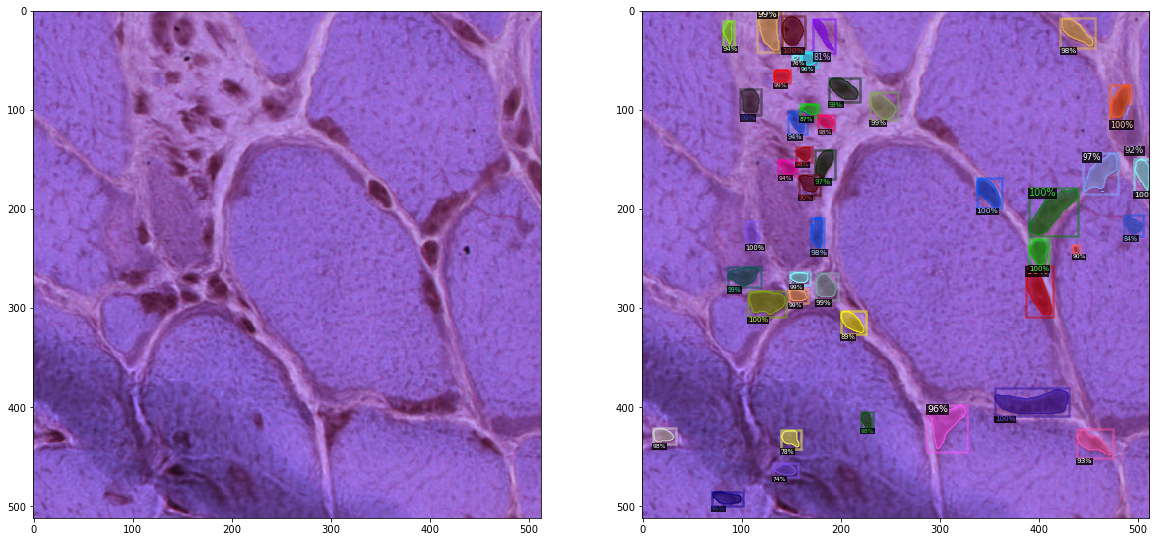

number of predicted instances: 14


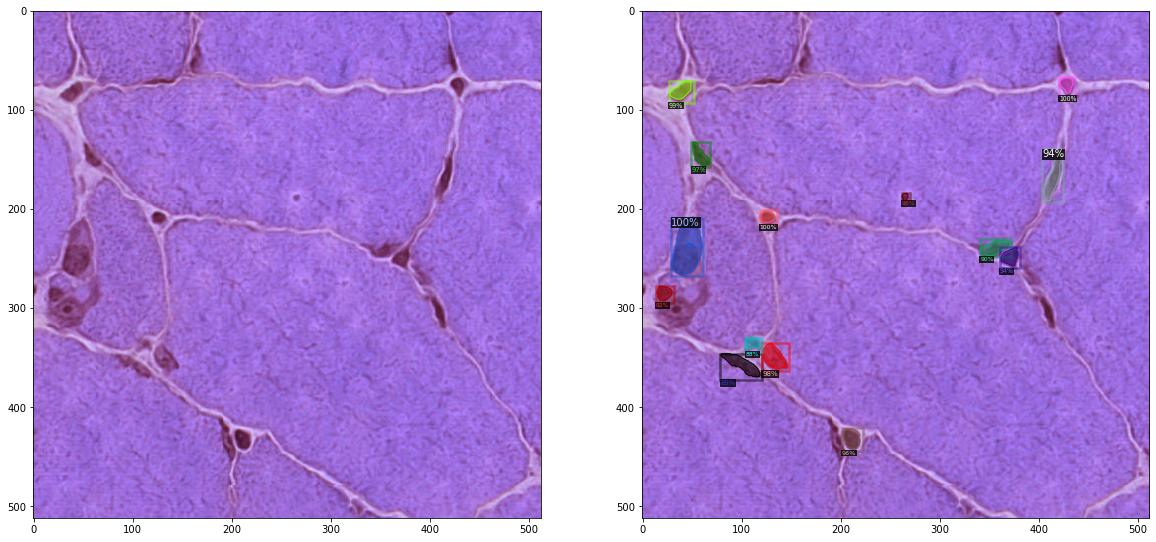

number of predicted instances: 23


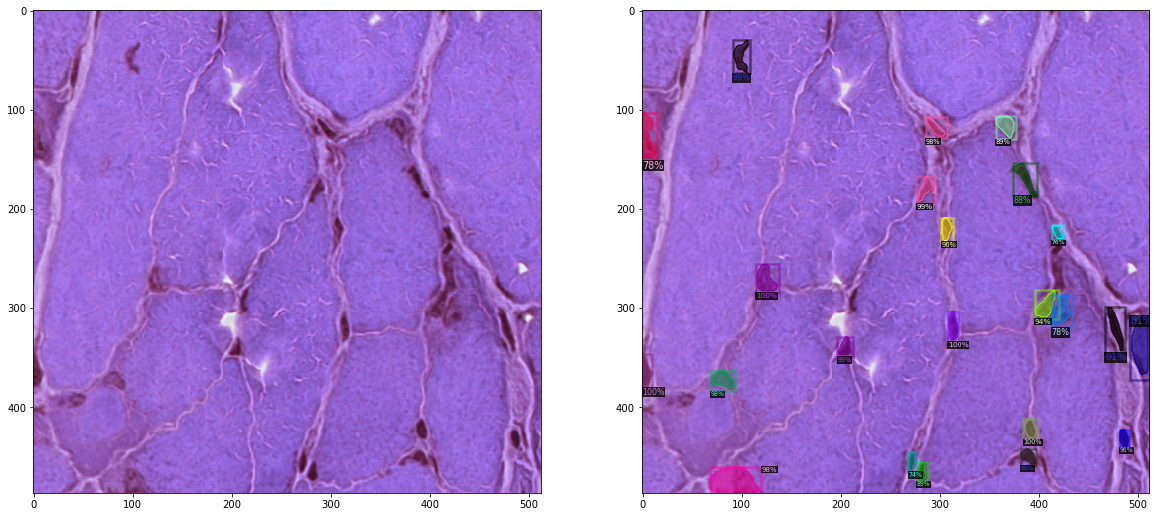

number of predicted instances: 23


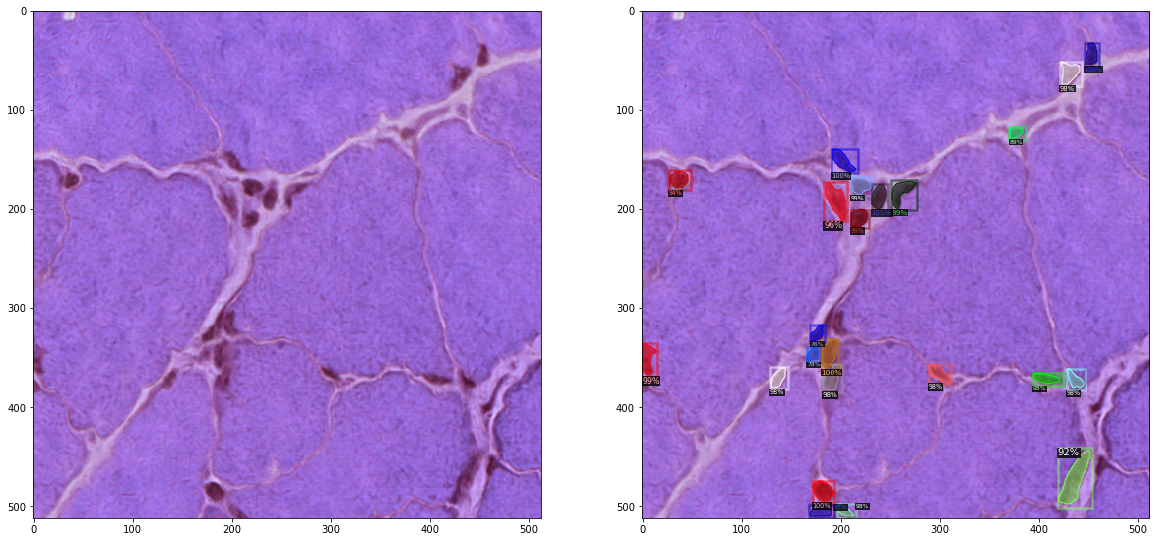

number of predicted instances: 24


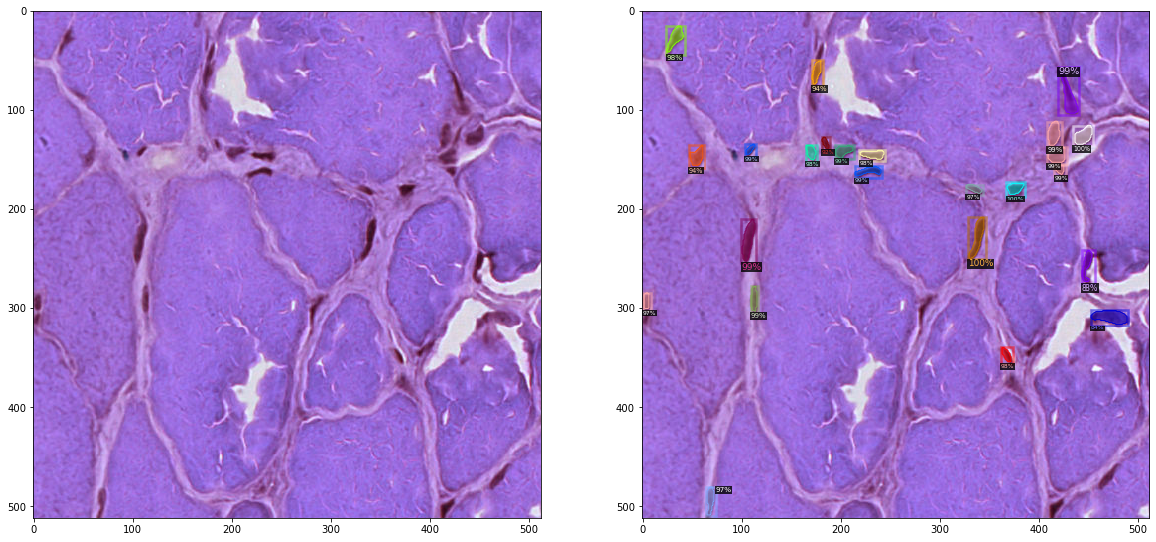

In [65]:
nuclei_metadata_muscle = MetadataCatalog.get(f"nuclei_muscle")
for p in random.sample(img_paths_muscles, 5):
    img = cv2.imread(str(p))
    pred = predictor(img)
    n_predicted = len(pred['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_muscle, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   
    )
    img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]
    
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_with_preds)
    plt.show()

In [48]:
#https://detectron2.readthedocs.io/tutorials/data_loading.html
#https://detectron2.readthedocs.io/_modules/detectron2/data/dataset_mapper.html#DatasetMapper

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import copy
import logging
import numpy as np
import torch
from fvcore.common.file_io import PathManager
from PIL import Image

from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

"""
This file contains the default mapping that's applied to "dataset dicts".
"""

__all__ = ["DatasetMapper"]


class DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is the default callable to be used to map your dataset dict into training data.
    You may need to follow it to implement your own one for customized logic,
    such as a different way to read or transform images.
    See :doc:`/tutorials/data_loading` for details.

    The callable currently does the following:

    1. Read the image from "file_name"
    2. Applies cropping/geometric transforms to the image and annotations
    3. Prepare data and annotations to Tensor and :class:`Instances`
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train


    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        
        
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        
        
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)

        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            with PathManager.open(dataset_dict.pop("sem_seg_file_name"), "rb") as f:
                sem_seg_gt = Image.open(f)
                sem_seg_gt = np.asarray(sem_seg_gt, dtype="uint8")
            sem_seg_gt = transforms.apply_segmentation(sem_seg_gt)
            sem_seg_gt = torch.as_tensor(sem_seg_gt.astype("long"))
            dataset_dict["sem_seg"] = sem_seg_gt
        return dataset_dict